DataLoader + U-Net 2D

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import scipy.ndimage as ndi
from tqdm import tqdm
import pandas as pd
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Configuration GPU/CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Device: {device}")

🖥️ Device: cpu


In [2]:
DATASET_PATH = r"C:\Users\ayoub\Downloads\Task04_Hippocampus\Task04_Hippocampus"  # À MODIFIER !
PREPROCESSED_PATH = os.path.join(DATASET_PATH, "preprocessed")
RESULTS_PATH = os.path.join(DATASET_PATH, "results")
os.makedirs(RESULTS_PATH, exist_ok=True)

print(f"✅ Configuration prête!")


✅ Configuration prête!


Charger les informations de split

In [4]:
with open(os.path.join(PREPROCESSED_PATH, 'split_info.json'), 'r') as f:
    split_info = json.load(f)

train_files = split_info['train']
val_files = split_info['val']
target_size = tuple(split_info['target_size'])

print(f"📊 DONNÉES DISPONIBLES:")
print(f"  Train: {len(train_files)} volumes")
print(f"  Validation: {len(val_files)} volumes")
print(f"  Taille: {target_size}")

📊 DONNÉES DISPONIBLES:
  Train: 208 volumes
  Validation: 52 volumes
  Taille: (64, 64, 64)


Fonctions d'augmentation 

In [5]:
def random_flip_3d(image, label, axes=[0, 1]):
    """Flip aléatoire selon axes X et Y"""
    for axis in axes:
        if np.random.rand() > 0.5:
            image = np.flip(image, axis=axis)
            label = np.flip(label, axis=axis)
    return image.copy(), label.copy()

def random_rotation_3d(image, label, angle_range=(-10, 10)):
    """Rotation aléatoire autour de Z"""
    angle = np.random.uniform(angle_range[0], angle_range[1])
    image_rot = ndi.rotate(image, angle, axes=(0, 1), reshape=False, order=1)
    label_rot = ndi.rotate(label, angle, axes=(0, 1), reshape=False, order=0)
    return image_rot, label_rot

def random_noise(image, noise_variance=0.01):
    """Bruit gaussien"""
    noise = np.random.normal(0, noise_variance, image.shape)
    return image + noise

def random_intensity_shift(image, shift_range=(-0.1, 0.1)):
    """Shift d'intensité"""
    shift = np.random.uniform(shift_range[0], shift_range[1])
    return image + shift

print("✅ Fonctions d'augmentation définies")

✅ Fonctions d'augmentation définies


Dataset PyTorch

In [6]:
class HippocampusDataset2D(Dataset):
    """
    Dataset 2D: extrait des slices 2D depuis les volumes 3D
    
    Args:
        file_list: liste des fichiers
        preprocessed_path: chemin vers les données preprocessées
        split: 'train' ou 'val'
        augment_config: dict des augmentations à appliquer
    """
    def __init__(self, file_list, preprocessed_path, split='train', augment_config=None):
        self.file_list = file_list
        self.preprocessed_path = preprocessed_path
        self.split = split
        self.augment_config = augment_config or {}
        
        # Construire la liste de toutes les slices 2D
        self.slices = []
        for file_info in file_list:
            base_name = file_info['image'].replace('.nii.gz', '')
            img_path = os.path.join(preprocessed_path, split, f"{base_name}_img.npy")
            lbl_path = os.path.join(preprocessed_path, split, f"{base_name}_lbl.npy")
            
            # Charger pour connaître le nombre de slices
            if os.path.exists(img_path):
                volume = np.load(img_path)
                num_slices = volume.shape[2]
                
                for slice_idx in range(num_slices):
                    self.slices.append({
                        'volume_path': img_path,
                        'label_path': lbl_path,
                        'slice_idx': slice_idx
                    })
        
        print(f"  {split}: {len(self.slices)} slices 2D (depuis {len(file_list)} volumes)")
    
    def __len__(self):
        return len(self.slices)
    
    def __getitem__(self, idx):
        slice_info = self.slices[idx]
        
        # Charger le volume 3D
        volume = np.load(slice_info['volume_path'])
        label = np.load(slice_info['label_path'])
        
        # Extraire la slice 2D
        slice_idx = slice_info['slice_idx']
        image_2d = volume[:, :, slice_idx]
        label_2d = label[:, :, slice_idx]
        
        # Augmentation (si configuré)
        if self.augment_config:
            if self.augment_config.get('flip', False) and np.random.rand() > 0.5:
                image_2d = np.flip(image_2d, axis=0).copy()
                label_2d = np.flip(label_2d, axis=0).copy()
            
            if self.augment_config.get('rotation', False) and np.random.rand() > 0.7:
                angle = np.random.uniform(-10, 10)
                image_2d = ndi.rotate(image_2d, angle, reshape=False, order=1)
                label_2d = ndi.rotate(label_2d, angle, reshape=False, order=0)
            
            if self.augment_config.get('noise', False) and np.random.rand() > 0.7:
                noise = np.random.normal(0, 0.01, image_2d.shape)
                image_2d = image_2d + noise
        
        # Convertir en tenseur PyTorch
        image_2d = torch.from_numpy(image_2d).float().unsqueeze(0)  # (1, H, W)
        label_2d = torch.from_numpy(label_2d).long()  # (H, W)
        
        return image_2d, label_2d

print("✅ Dataset 2D défini")

✅ Dataset 2D défini


EXPÉRIENCE 1 - DataLoader sans augmentation 

In [7]:
print("🧪 EXPÉRIENCE 1: DataLoader SANS augmentation")
print("=" * 60)

# Configuration
EXP1_CONFIG = {
    'name': 'Baseline (No Augmentation)',
    'augmentation': None,
    'batch_size': 16
}

# Créer les datasets
train_dataset_exp1 = HippocampusDataset2D(
    train_files, 
    PREPROCESSED_PATH, 
    split='train',
    augment_config=None  # PAS d'augmentation
)

val_dataset_exp1 = HippocampusDataset2D(
    val_files,
    PREPROCESSED_PATH,
    split='val',
    augment_config=None
)

# DataLoaders
train_loader_exp1 = DataLoader(
    train_dataset_exp1,
    batch_size=EXP1_CONFIG['batch_size'],
    shuffle=True,
    num_workers=0
)

val_loader_exp1 = DataLoader(
    val_dataset_exp1,
    batch_size=EXP1_CONFIG['batch_size'],
    shuffle=False,
    num_workers=0
)

print(f"✅ EXP1 DataLoaders créés")
print(f"  Train batches: {len(train_loader_exp1)}")
print(f"  Val batches: {len(val_loader_exp1)}")

# Test
images, labels = next(iter(train_loader_exp1))
print(f"\n🧪 Test de chargement:")
print(f"  Batch images: {images.shape}")  # (batch, 1, H, W)
print(f"  Batch labels: {labels.shape}")  # (batch, H, W)
print(f"  Label classes: {torch.unique(labels)}")



🧪 EXPÉRIENCE 1: DataLoader SANS augmentation
  train: 13312 slices 2D (depuis 208 volumes)
  val: 3328 slices 2D (depuis 52 volumes)
✅ EXP1 DataLoaders créés
  Train batches: 832
  Val batches: 208

🧪 Test de chargement:
  Batch images: torch.Size([16, 1, 64, 64])
  Batch labels: torch.Size([16, 64, 64])
  Label classes: tensor([0, 1, 2])


EXPÉRIENCE 2 - DataLoader avec FLIP seulement

In [8]:
print("\n EXPÉRIENCE 2: DataLoader avec FLIP seulement")
print("=" * 60)

EXP2_CONFIG = {
    'name': 'Flip Only',
    'augmentation': {'flip': True, 'rotation': False, 'noise': False},
    'batch_size': 16
}

train_dataset_exp2 = HippocampusDataset2D(
    train_files,
    PREPROCESSED_PATH,
    split='train',
    augment_config=EXP2_CONFIG['augmentation']
)

train_loader_exp2 = DataLoader(
    train_dataset_exp2,
    batch_size=EXP2_CONFIG['batch_size'],
    shuffle=True,
    num_workers=0
)

print(f"✅ EXP2 DataLoader créé (train avec flip)")


 EXPÉRIENCE 2: DataLoader avec FLIP seulement
  train: 13312 slices 2D (depuis 208 volumes)
✅ EXP2 DataLoader créé (train avec flip)


EXPÉRIENCE 3 - DataLoader avec FLIP + ROTATION

In [9]:
print("\nEXPÉRIENCE 3: DataLoader avec FLIP + ROTATION")
print("=" * 60)

EXP3_CONFIG = {
    'name': 'Flip + Rotation',
    'augmentation': {'flip': True, 'rotation': True, 'noise': False},
    'batch_size': 16
}

train_dataset_exp3 = HippocampusDataset2D(
    train_files,
    PREPROCESSED_PATH,
    split='train',
    augment_config=EXP3_CONFIG['augmentation']
)

train_loader_exp3 = DataLoader(
    train_dataset_exp3,
    batch_size=EXP3_CONFIG['batch_size'],
    shuffle=True,
    num_workers=0
)

print(f"✅ EXP3 DataLoader créé (train avec flip + rotation)")


EXPÉRIENCE 3: DataLoader avec FLIP + ROTATION
  train: 13312 slices 2D (depuis 208 volumes)
✅ EXP3 DataLoader créé (train avec flip + rotation)


EXPÉRIENCE 4 - DataLoader avec TOUTES les augmentations

In [10]:
print("\n EXPÉRIENCE 4: DataLoader avec TOUTES les augmentations")
print("=" * 60)

EXP4_CONFIG = {
    'name': 'Full Augmentation',
    'augmentation': {'flip': True, 'rotation': True, 'noise': True},
    'batch_size': 16
}

train_dataset_exp4 = HippocampusDataset2D(
    train_files,
    PREPROCESSED_PATH,
    split='train',
    augment_config=EXP4_CONFIG['augmentation']
)

train_loader_exp4 = DataLoader(
    train_dataset_exp4,
    batch_size=EXP4_CONFIG['batch_size'],
    shuffle=True,
    num_workers=0
)

print(f"✅ EXP4 DataLoader créé (train avec toutes augmentations)")


 EXPÉRIENCE 4: DataLoader avec TOUTES les augmentations
  train: 13312 slices 2D (depuis 208 volumes)
✅ EXP4 DataLoader créé (train avec toutes augmentations)


Visualisation des augmentations


 VISUALISATION DES AUGMENTATIONS


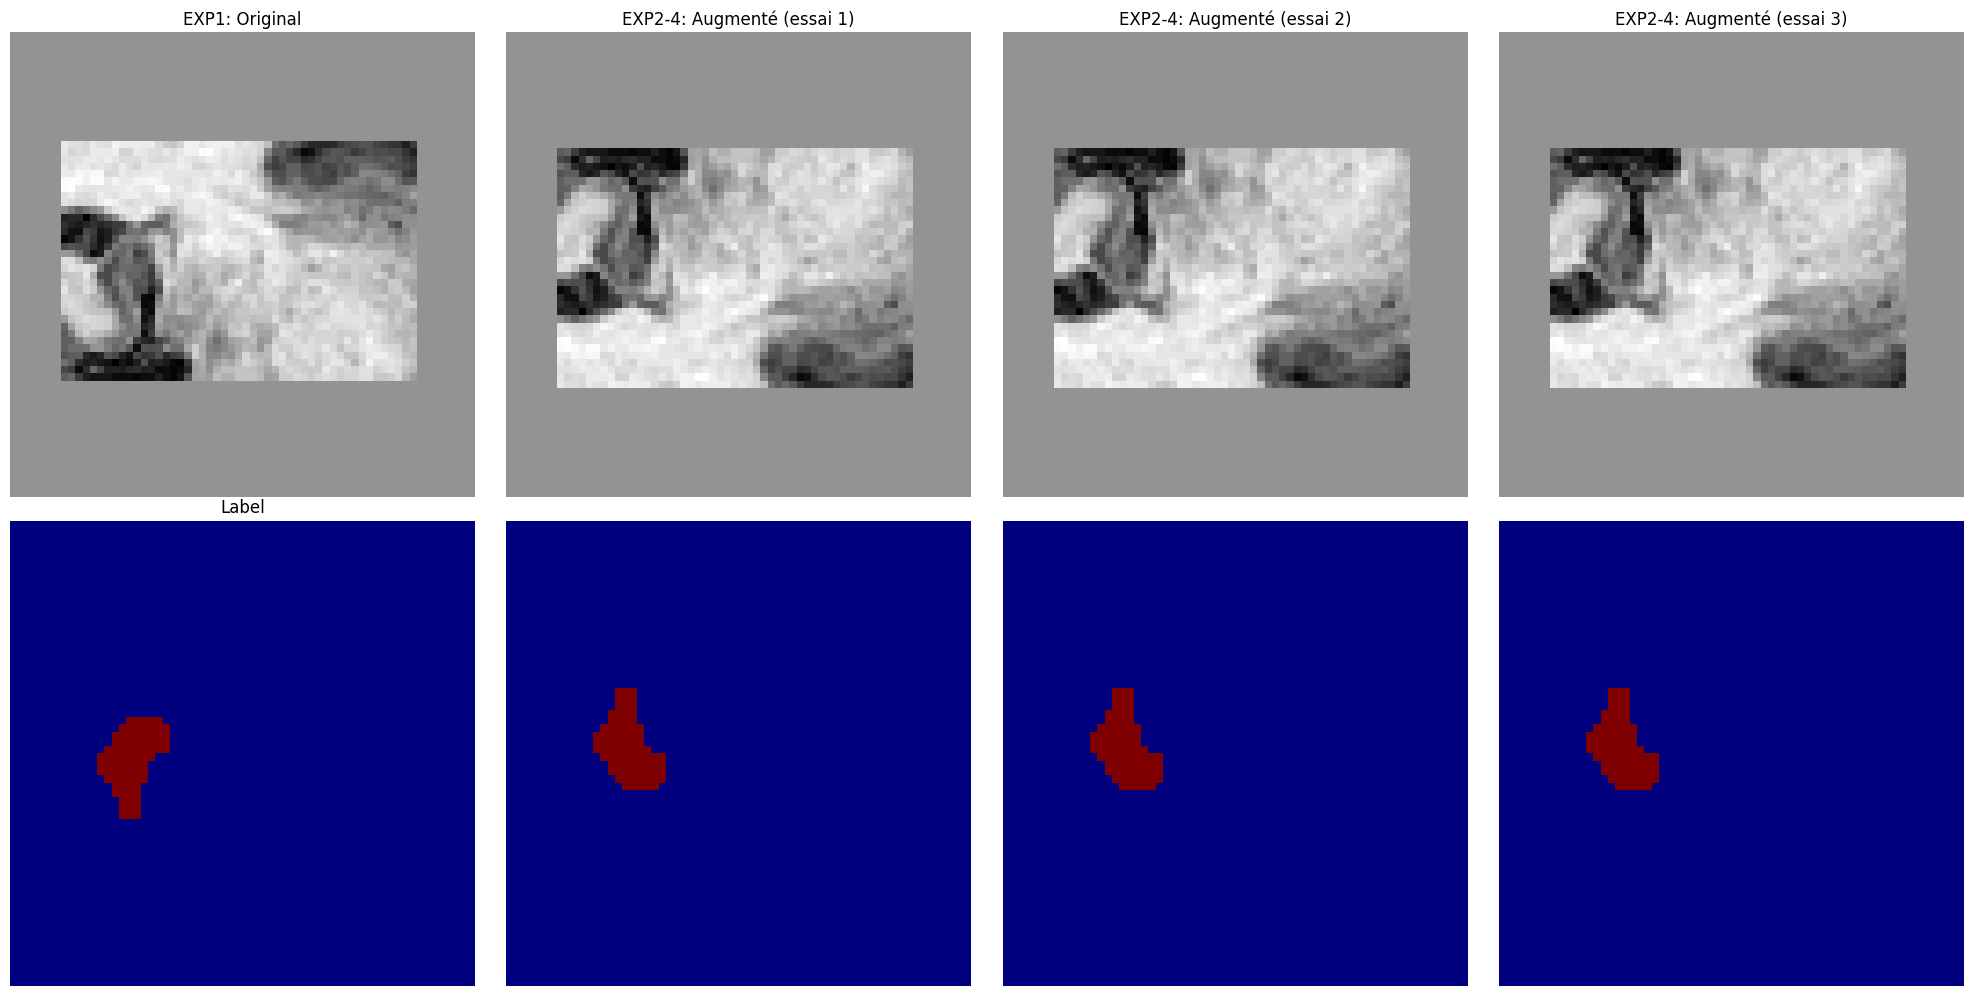

✅ Visualisation sauvegardée: augmentation_comparison.png


In [11]:
print("\n VISUALISATION DES AUGMENTATIONS")
print("=" * 60)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Charger une slice
sample_img, sample_lbl = train_dataset_exp1[1000]  # Sans augmentation

# EXP1: Sans augmentation
axes[0, 0].imshow(sample_img.squeeze(), cmap='gray')
axes[0, 0].set_title('EXP1: Original')
axes[0, 0].axis('off')
axes[1, 0].imshow(sample_lbl, cmap='jet', vmin=0, vmax=2)
axes[1, 0].set_title('Label')
axes[1, 0].axis('off')

# EXP2: Avec flip (charger plusieurs fois pour voir la variabilité)
for i in range(3):
    sample_img_aug, sample_lbl_aug = train_dataset_exp2[1000]
    axes[0, i+1].imshow(sample_img_aug.squeeze(), cmap='gray')
    axes[0, i+1].set_title(f'EXP2-4: Augmenté (essai {i+1})')
    axes[0, i+1].axis('off')
    axes[1, i+1].imshow(sample_lbl_aug, cmap='jet', vmin=0, vmax=2)
    axes[1, i+1].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'augmentation_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Visualisation sauvegardée: augmentation_comparison.png")



Architecture U-Net 2D

In [12]:
class UNet2D(nn.Module):
    def __init__(self, in_channels=1, num_classes=3, base_filters=32):
        super(UNet2D, self).__init__()
        
        # Encoder (contraction path)
        self.enc1 = self.conv_block(in_channels, base_filters)
        self.enc2 = self.conv_block(base_filters, base_filters * 2)
        self.enc3 = self.conv_block(base_filters * 2, base_filters * 4)
        self.enc4 = self.conv_block(base_filters * 4, base_filters * 8)
        
        # Bottleneck
        self.bottleneck = self.conv_block(base_filters * 8, base_filters * 16)
        
        # Decoder (expansion path)
        self.upconv4 = nn.ConvTranspose2d(base_filters * 16, base_filters * 8, 2, stride=2)
        self.dec4 = self.conv_block(base_filters * 16, base_filters * 8)
        
        self.upconv3 = nn.ConvTranspose2d(base_filters * 8, base_filters * 4, 2, stride=2)
        self.dec3 = self.conv_block(base_filters * 8, base_filters * 4)
        
        self.upconv2 = nn.ConvTranspose2d(base_filters * 4, base_filters * 2, 2, stride=2)
        self.dec2 = self.conv_block(base_filters * 4, base_filters * 2)
        
        self.upconv1 = nn.ConvTranspose2d(base_filters * 2, base_filters, 2, stride=2)
        self.dec1 = self.conv_block(base_filters * 2, base_filters)
        
        # Output
        self.out = nn.Conv2d(base_filters, num_classes, 1)
        
        # Max pooling
        self.pool = nn.MaxPool2d(2)
    
    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc4))
        
        # Decoder with skip connections
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.dec4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.dec1(dec1)
        
        return self.out(dec1)

# Test
model = UNet2D(in_channels=1, num_classes=3, base_filters=32).to(device)
test_input = torch.randn(2, 1, 64, 64).to(device)
test_output = model(test_input)

print(f"✅ U-Net 2D défini")
print(f"  Input: {test_input.shape}")
print(f"  Output: {test_output.shape}")
print(f"  Paramètres: {sum(p.numel() for p in model.parameters()):,}")

✅ U-Net 2D défini
  Input: torch.Size([2, 1, 64, 64])
  Output: torch.Size([2, 3, 64, 64])
  Paramètres: 7,765,475


Loss Functions 

In [13]:
class DiceLoss(nn.Module):
    """Dice Loss pour segmentation"""
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, pred, target):
        # pred: (batch, num_classes, H, W)
        # target: (batch, H, W)
        
        pred = torch.softmax(pred, dim=1)
        target_one_hot = torch.nn.functional.one_hot(target, num_classes=pred.shape[1])
        target_one_hot = target_one_hot.permute(0, 3, 1, 2).float()
        
        intersection = (pred * target_one_hot).sum(dim=(2, 3))
        union = pred.sum(dim=(2, 3)) + target_one_hot.sum(dim=(2, 3))
        
        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

class CombinedLoss(nn.Module):
    """Combinaison Dice + CrossEntropy"""
    def __init__(self, weight_dice=0.5, weight_ce=0.5):
        super(CombinedLoss, self).__init__()
        self.dice_loss = DiceLoss()
        self.ce_loss = nn.CrossEntropyLoss()
        self.weight_dice = weight_dice
        self.weight_ce = weight_ce
    
    def forward(self, pred, target):
        dice = self.dice_loss(pred, target)
        ce = self.ce_loss(pred, target)
        return self.weight_dice * dice + self.weight_ce * ce

print(" Loss functions définies:")
print("  1. CrossEntropyLoss ")
print("  2. DiceLoss ")
print("  3. CombinedLoss (Dice + CE)")

 Loss functions définies:
  1. CrossEntropyLoss 
  2. DiceLoss 
  3. CombinedLoss (Dice + CE)


Fonctions d'entraînement et d'évaluation

In [14]:
def dice_score(pred, target, num_classes=3):
    """Calculer le Dice Score"""
    pred = torch.softmax(pred, dim=1)
    pred = torch.argmax(pred, dim=1)
    
    dice_scores = []
    for c in range(num_classes):
        pred_c = (pred == c).float()
        target_c = (target == c).float()
        
        intersection = (pred_c * target_c).sum()
        union = pred_c.sum() + target_c.sum()
        
        if union == 0:
            dice_scores.append(1.0)
        else:
            dice_scores.append((2.0 * intersection / union).item())
    
    return dice_scores

def train_epoch(model, loader, criterion, optimizer, device):
    """Une epoch d'entraînement"""
    model.train()
    total_loss = 0
    
    for images, labels in tqdm(loader, desc='Training', leave=False):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)

def validate(model, loader, criterion, device):
    """Validation"""
    model.eval()
    total_loss = 0
    dice_scores_all = defaultdict(list)
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validation', leave=False):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # Dice score
            scores = dice_score(outputs, labels)
            for i, score in enumerate(scores):
                dice_scores_all[f'class_{i}'].append(score)
    
    # Moyennes
    avg_dice = {k: np.mean(v) for k, v in dice_scores_all.items()}
    
    return total_loss / len(loader), avg_dice

print("✅ Fonctions d'entraînement définies")


✅ Fonctions d'entraînement définies


Résumé des expériences à lancer

📋 PLAN DES EXPÉRIENCES

À exécuter dans les notebooks/cellules suivants:

🧪 SÉRIE 1: Impact des augmentations (même loss: DiceLoss)

  EXP1: No augmentation

  EXP2: Flip only

  EXP3: Flip + Rotation

  EXP4: Full augmentation
  
🧪 SÉRIE 2: Impact de la loss function (avec best augmentation)

  EXP5: CrossEntropyLoss

  EXP6: DiceLoss

  EXP7: CombinedLoss
  
🧪 SÉRIE 3: Variations d'architecture

  EXP8: UNet base_filters=16 (plus léger)

  EXP9: UNet base_filters=32 (baseline)

  EXP10: UNet base_filters=64 (plus profond)


📊 MÉTRIQUES À COMPARER:
  - Training loss (courbe)
  - Validation loss (courbe)
  - Dice Score par classe
  - Dice Score moyen
  - Temps d'entraînement
  - Mémoire GPU utilisée

💾 SAUVEGARDE:
  Chaque expérience sauvegarde:
  - Modèle (.pth)
  - Historique (loss, dice) (.json)
  - Graphiques (loss curves)
  - Exemples de prédictions

Configuration globale des expériences

In [15]:
# Paramètres d'entraînement
NUM_EPOCHS = 10  # Ajuste selon ton temps disponible (10-20 epochs)
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

# Dictionnaire pour sauvegarder tous les résultats
EXPERIMENTS_RESULTS = {}

print("⚙️ CONFIGURATION DES EXPÉRIENCES")
print("=" * 70)
print(f"  Epochs par expérience: {NUM_EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Device: {device}")
print(f"  Batch size: 16")
print("=" * 70)


⚙️ CONFIGURATION DES EXPÉRIENCES
  Epochs par expérience: 10
  Learning rate: 0.0001
  Device: cpu
  Batch size: 16


 EXPÉRIENCE 1 - BASELINE 

In [19]:
print("\n" + "🧪" * 35)
print("EXPÉRIENCE 1: BASELINE (No Augmentation + DiceLoss)")
print("🧪" * 35)

exp1_config = {
    'name': 'EXP1_NoAug_DiceLoss',
    'augmentation': 'None',
    'loss': 'DiceLoss',
    'base_filters': 32
}

# Modèle
model_exp1 = UNet2D(in_channels=1, num_classes=3, base_filters=32).to(device)
criterion_exp1 = DiceLoss()
optimizer_exp1 = optim.Adam(model_exp1.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Historique
history_exp1 = {
    'train_loss': [],
    'val_loss': [],
    'val_dice': []
}

print(f"\n📊 Entraînement EXP1 ({NUM_EPOCHS} epochs)...")
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    
    # Train
    train_loss = train_epoch(model_exp1, train_loader_exp1, criterion_exp1, optimizer_exp1, device)
    history_exp1['train_loss'].append(train_loss)
    
    # Validation
    val_loss, val_dice = validate(model_exp1, val_loader_exp1, criterion_exp1, device)
    history_exp1['val_loss'].append(val_loss)
    history_exp1['val_dice'].append(val_dice)
    
    avg_dice = np.mean([v for v in val_dice.values()])
    print(f"  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Avg Dice: {avg_dice:.4f}")

# Sauvegarder
EXPERIMENTS_RESULTS['EXP1'] = {
    'config': exp1_config,
    'history': history_exp1,
    'final_dice': avg_dice
}

torch.save(model_exp1.state_dict(), os.path.join(RESULTS_PATH, 'exp1_model.pth'))

print(f"\n✅ EXP1 terminée - Dice Score final: {avg_dice:.4f}")


🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪
EXPÉRIENCE 1: BASELINE (No Augmentation + DiceLoss)
🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪

📊 Entraînement EXP1 (10 epochs)...

Epoch 1/10


  Train Loss: 0.6710 | Val Loss: 0.5820 | Avg Dice: 0.8121

Epoch 2/10


  Train Loss: 0.5183 | Val Loss: 0.4504 | Avg Dice: 0.8866

Epoch 3/10


  Train Loss: 0.3395 | Val Loss: 0.1282 | Avg Dice: 0.9049

Epoch 4/10


  Train Loss: 0.0754 | Val Loss: 0.0634 | Avg Dice: 0.9048

Epoch 5/10


  Train Loss: 0.0504 | Val Loss: 0.0508 | Avg Dice: 0.9172

Epoch 6/10


  Train Loss: 0.0440 | Val Loss: 0.0466 | Avg Dice: 0.9239

Epoch 7/10


  Train Loss: 0.0428 | Val Loss: 0.0463 | Avg Dice: 0.9188

Epoch 8/10


  Train Loss: 0.0426 | Val Loss: 0.0444 | Avg Dice: 0.9211

Epoch 9/10


  Train Loss: 0.0403 | Val Loss: 0.0462 | Avg Dice: 0.9102

Epoch 10/10


  Train Loss: 0.0404 | Val Loss: 0.0442 | Avg Dice: 0.9225

✅ EXP1 terminée - Dice Score final: 0.9225


EXPÉRIENCE 2 - Flip Only

In [20]:
print("\n" + "🧪" * 35)
print("EXPÉRIENCE 2: FLIP ONLY + DiceLoss")
print("🧪" * 35)

exp2_config = {
    'name': 'EXP2_FlipOnly_DiceLoss',
    'augmentation': 'Flip',
    'loss': 'DiceLoss',
    'base_filters': 32
}

# Modèle
model_exp2 = UNet2D(in_channels=1, num_classes=3, base_filters=32).to(device)
criterion_exp2 = DiceLoss()
optimizer_exp2 = optim.Adam(model_exp2.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Historique
history_exp2 = {
    'train_loss': [],
    'val_loss': [],
    'val_dice': []
}

print(f"\n📊 Entraînement EXP2 ({NUM_EPOCHS} epochs)...")
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    
    train_loss = train_epoch(model_exp2, train_loader_exp2, criterion_exp2, optimizer_exp2, device)
    history_exp2['train_loss'].append(train_loss)
    
    val_loss, val_dice = validate(model_exp2, val_loader_exp1, criterion_exp2, device)
    history_exp2['val_loss'].append(val_loss)
    history_exp2['val_dice'].append(val_dice)
    
    avg_dice = np.mean([v for v in val_dice.values()])
    print(f"  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Avg Dice: {avg_dice:.4f}")

EXPERIMENTS_RESULTS['EXP2'] = {
    'config': exp2_config,
    'history': history_exp2,
    'final_dice': avg_dice
}

torch.save(model_exp2.state_dict(), os.path.join(RESULTS_PATH, 'exp2_model.pth'))

print(f"\n✅ EXP2 terminée - Dice Score final: {avg_dice:.4f}")


🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪
EXPÉRIENCE 2: FLIP ONLY + DiceLoss
🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪

📊 Entraînement EXP2 (10 epochs)...

Epoch 1/10


  Train Loss: 0.6590 | Val Loss: 0.5748 | Avg Dice: 0.8120

Epoch 2/10


  Train Loss: 0.5078 | Val Loss: 0.3992 | Avg Dice: 0.5760

Epoch 3/10


  Train Loss: 0.2771 | Val Loss: 0.0928 | Avg Dice: 0.8959

Epoch 4/10


  Train Loss: 0.0657 | Val Loss: 0.0534 | Avg Dice: 0.9150

Epoch 5/10


  Train Loss: 0.0529 | Val Loss: 0.0508 | Avg Dice: 0.9178

Epoch 6/10


  Train Loss: 0.0488 | Val Loss: 0.0493 | Avg Dice: 0.9096

Epoch 7/10


  Train Loss: 0.0463 | Val Loss: 0.0465 | Avg Dice: 0.9203

Epoch 8/10


  Train Loss: 0.0461 | Val Loss: 0.0481 | Avg Dice: 0.9123

Epoch 9/10


  Train Loss: 0.0444 | Val Loss: 0.0454 | Avg Dice: 0.9150

Epoch 10/10


  Train Loss: 0.0461 | Val Loss: 0.0474 | Avg Dice: 0.9176

✅ EXP2 terminée - Dice Score final: 0.9176


EXPÉRIENCE 3 - Flip + Rotation

In [15]:
print("\n" + "🧪" * 35)
print("EXPÉRIENCE 3: FLIP + ROTATION + DiceLoss")
print("🧪" * 35)

exp3_config = {
    'name': 'EXP3_FlipRotation_DiceLoss',
    'augmentation': 'Flip + Rotation',
    'loss': 'DiceLoss',
    'base_filters': 32
}

model_exp3 = UNet2D(in_channels=1, num_classes=3, base_filters=32).to(device)
criterion_exp3 = DiceLoss()
optimizer_exp3 = optim.Adam(model_exp3.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

history_exp3 = {
    'train_loss': [],
    'val_loss': [],
    'val_dice': []
}

print(f"\n📊 Entraînement EXP3 ({NUM_EPOCHS} epochs)...")
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    
    train_loss = train_epoch(model_exp3, train_loader_exp3, criterion_exp3, optimizer_exp3, device)
    history_exp3['train_loss'].append(train_loss)
    
    val_loss, val_dice = validate(model_exp3, val_loader_exp1, criterion_exp3, device)
    history_exp3['val_loss'].append(val_loss)
    history_exp3['val_dice'].append(val_dice)
    
    avg_dice = np.mean([v for v in val_dice.values()])
    print(f"  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Avg Dice: {avg_dice:.4f}")

EXPERIMENTS_RESULTS['EXP3'] = {
    'config': exp3_config,
    'history': history_exp3,
    'final_dice': avg_dice
}

torch.save(model_exp3.state_dict(), os.path.join(RESULTS_PATH, 'exp3_model.pth'))

print(f"\n✅ EXP3 terminée - Dice Score final: {avg_dice:.4f}")


🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪
EXPÉRIENCE 3: FLIP + ROTATION + DiceLoss
🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪

📊 Entraînement EXP3 (10 epochs)...

Epoch 1/10


  Train Loss: 0.6837 | Val Loss: 0.5912 | Avg Dice: 0.7759

Epoch 2/10


  Train Loss: 0.5467 | Val Loss: 0.4187 | Avg Dice: 0.9041

Epoch 3/10


  Train Loss: 0.3174 | Val Loss: 0.1178 | Avg Dice: 0.9119

Epoch 4/10


  Train Loss: 0.0704 | Val Loss: 0.0683 | Avg Dice: 0.8993

Epoch 5/10


  Train Loss: 0.0535 | Val Loss: 0.0495 | Avg Dice: 0.9191

Epoch 6/10


  Train Loss: 0.0508 | Val Loss: 0.0480 | Avg Dice: 0.9150

Epoch 7/10


  Train Loss: 0.0471 | Val Loss: 0.0474 | Avg Dice: 0.9158

Epoch 8/10


  Train Loss: 0.0473 | Val Loss: 0.0468 | Avg Dice: 0.9161

Epoch 9/10


  Train Loss: 0.0463 | Val Loss: 0.0464 | Avg Dice: 0.9185

Epoch 10/10


  Train Loss: 0.0471 | Val Loss: 0.0458 | Avg Dice: 0.9178

✅ EXP3 terminée - Dice Score final: 0.9178


 EXPÉRIENCE 4 - Full Augmentation

In [16]:
print("\n" + "🧪" * 35)
print("EXPÉRIENCE 4: FULL AUGMENTATION + DiceLoss")
print("🧪" * 35)

exp4_config = {
    'name': 'EXP4_FullAug_DiceLoss',
    'augmentation': 'Full (Flip + Rotation + Noise)',
    'loss': 'DiceLoss',
    'base_filters': 32
}

model_exp4 = UNet2D(in_channels=1, num_classes=3, base_filters=32).to(device)
criterion_exp4 = DiceLoss()
optimizer_exp4 = optim.Adam(model_exp4.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

history_exp4 = {
    'train_loss': [],
    'val_loss': [],
    'val_dice': []
}

print(f"\n📊 Entraînement EXP4 ({NUM_EPOCHS} epochs)...")
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    
    train_loss = train_epoch(model_exp4, train_loader_exp4, criterion_exp4, optimizer_exp4, device)
    history_exp4['train_loss'].append(train_loss)
    
    val_loss, val_dice = validate(model_exp4, val_loader_exp1, criterion_exp4, device)
    history_exp4['val_loss'].append(val_loss)
    history_exp4['val_dice'].append(val_dice)
    
    avg_dice = np.mean([v for v in val_dice.values()])
    print(f"  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Avg Dice: {avg_dice:.4f}")

EXPERIMENTS_RESULTS['EXP4'] = {
    'config': exp4_config,
    'history': history_exp4,
    'final_dice': avg_dice
}

torch.save(model_exp4.state_dict(), os.path.join(RESULTS_PATH, 'exp4_model.pth'))

print(f"\n✅ EXP4 terminée - Dice Score final: {avg_dice:.4f}")



🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪
EXPÉRIENCE 4: FULL AUGMENTATION + DiceLoss
🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪

📊 Entraînement EXP4 (10 epochs)...

Epoch 1/10


  Train Loss: 0.6429 | Val Loss: 0.5696 | Avg Dice: 0.8095

Epoch 2/10


  Train Loss: 0.5023 | Val Loss: 0.3873 | Avg Dice: 0.9022

Epoch 3/10


  Train Loss: 0.3104 | Val Loss: 0.1077 | Avg Dice: 0.9105

Epoch 4/10


  Train Loss: 0.0690 | Val Loss: 0.0555 | Avg Dice: 0.9034

Epoch 5/10


  Train Loss: 0.0511 | Val Loss: 0.0534 | Avg Dice: 0.9137

Epoch 6/10


  Train Loss: 0.0491 | Val Loss: 0.0494 | Avg Dice: 0.9167

Epoch 7/10


  Train Loss: 0.0465 | Val Loss: 0.0513 | Avg Dice: 0.9098

Epoch 8/10


  Train Loss: 0.0464 | Val Loss: 0.0477 | Avg Dice: 0.9145

Epoch 9/10


  Train Loss: 0.0460 | Val Loss: 0.0497 | Avg Dice: 0.9082

Epoch 10/10


  Train Loss: 0.0453 | Val Loss: 0.0469 | Avg Dice: 0.9138

✅ EXP4 terminée - Dice Score final: 0.9138


EXPÉRIENCE 5 - CrossEntropyLoss 

In [16]:
print("\n" + "🧪" * 35)
print("EXPÉRIENCE 5: Best Augmentation + CrossEntropyLoss")
print("🧪" * 35)

exp5_config = {
    'name': 'EXP5_BestAug_CrossEntropy',
    'augmentation': 'Flip + Rotation',  # Utilise la meilleure config précédente
    'loss': 'CrossEntropyLoss',
    'base_filters': 32
}

model_exp5 = UNet2D(in_channels=1, num_classes=3, base_filters=32).to(device)
criterion_exp5 = nn.CrossEntropyLoss()  # CrossEntropy au lieu de Dice
optimizer_exp5 = optim.Adam(model_exp5.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

history_exp5 = {
    'train_loss': [],
    'val_loss': [],
    'val_dice': []
}

print(f"\n📊 Entraînement EXP5 ({NUM_EPOCHS} epochs)...")
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    
    train_loss = train_epoch(model_exp5, train_loader_exp3, criterion_exp5, optimizer_exp5, device)
    history_exp5['train_loss'].append(train_loss)
    
    # Pour la validation, on utilise toujours DiceLoss pour comparer équitablement
    val_loss, val_dice = validate(model_exp5, val_loader_exp1, DiceLoss(), device)
    history_exp5['val_loss'].append(val_loss)
    history_exp5['val_dice'].append(val_dice)
    
    avg_dice = np.mean([v for v in val_dice.values()])
    print(f"  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Avg Dice: {avg_dice:.4f}")

EXPERIMENTS_RESULTS['EXP5'] = {
    'config': exp5_config,
    'history': history_exp5,
    'final_dice': avg_dice
}

torch.save(model_exp5.state_dict(), os.path.join(RESULTS_PATH, 'exp5_model.pth'))

print(f"\n✅ EXP5 terminée - Dice Score final: {avg_dice:.4f}")
print(f"⚠️ Attendu: Performance INFÉRIEURE aux expériences avec DiceLoss")


🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪
EXPÉRIENCE 5: Best Augmentation + CrossEntropyLoss
🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪

📊 Entraînement EXP5 (10 epochs)...

Epoch 1/10


  Train Loss: 0.3605 | Val Loss: 0.6431 | Avg Dice: 0.8841

Epoch 2/10


  Train Loss: 0.0835 | Val Loss: 0.5851 | Avg Dice: 0.9104

Epoch 3/10


  Train Loss: 0.0341 | Val Loss: 0.5514 | Avg Dice: 0.9166

Epoch 4/10


  Train Loss: 0.0195 | Val Loss: 0.5261 | Avg Dice: 0.9180

Epoch 5/10


  Train Loss: 0.0137 | Val Loss: 0.4986 | Avg Dice: 0.9196

Epoch 6/10


  Train Loss: 0.0106 | Val Loss: 0.4628 | Avg Dice: 0.9211

Epoch 7/10


  Train Loss: 0.0092 | Val Loss: 0.4437 | Avg Dice: 0.8630

Epoch 8/10


  Train Loss: 0.0083 | Val Loss: 0.3757 | Avg Dice: 0.9223

Epoch 9/10


  Train Loss: 0.0077 | Val Loss: 0.3224 | Avg Dice: 0.9248

Epoch 10/10


  Train Loss: 0.0074 | Val Loss: 0.2622 | Avg Dice: 0.9256

✅ EXP5 terminée - Dice Score final: 0.9256
⚠️ Attendu: Performance INFÉRIEURE aux expériences avec DiceLoss


EXPÉRIENCE 6 - Combined Loss

In [17]:
print("\n" + "🧪" * 35)
print("EXPÉRIENCE 6: Best Augmentation + CombinedLoss")
print("🧪" * 35)

exp6_config = {
    'name': 'EXP6_BestAug_Combined',
    'augmentation': 'Flip + Rotation',
    'loss': 'CombinedLoss (Dice + CE)',
    'base_filters': 32
}

model_exp6 = UNet2D(in_channels=1, num_classes=3, base_filters=32).to(device)
criterion_exp6 = CombinedLoss(weight_dice=0.7, weight_ce=0.3)
optimizer_exp6 = optim.Adam(model_exp6.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

history_exp6 = {
    'train_loss': [],
    'val_loss': [],
    'val_dice': []
}

print(f"\n📊 Entraînement EXP6 ({NUM_EPOCHS} epochs)...")
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    
    train_loss = train_epoch(model_exp6, train_loader_exp3, criterion_exp6, optimizer_exp6, device)
    history_exp6['train_loss'].append(train_loss)
    
    val_loss, val_dice = validate(model_exp6, val_loader_exp1, DiceLoss(), device)
    history_exp6['val_loss'].append(val_loss)
    history_exp6['val_dice'].append(val_dice)
    
    avg_dice = np.mean([v for v in val_dice.values()])
    print(f"  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Avg Dice: {avg_dice:.4f}")

EXPERIMENTS_RESULTS['EXP6'] = {
    'config': exp6_config,
    'history': history_exp6,
    'final_dice': avg_dice
}

torch.save(model_exp6.state_dict(), os.path.join(RESULTS_PATH, 'exp6_model.pth'))

print(f"\n EXP6 terminée - Dice Score final: {avg_dice:.4f}")


🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪
EXPÉRIENCE 6: Best Augmentation + CombinedLoss
🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪

📊 Entraînement EXP6 (10 epochs)...

Epoch 1/10


  Train Loss: 0.6377 | Val Loss: 0.6456 | Avg Dice: 0.9034

Epoch 2/10


  Train Loss: 0.4532 | Val Loss: 0.5531 | Avg Dice: 0.8955

Epoch 3/10


  Train Loss: 0.3681 | Val Loss: 0.4030 | Avg Dice: 0.8927

Epoch 4/10


  Train Loss: 0.1919 | Val Loss: 0.0990 | Avg Dice: 0.9038

Epoch 5/10


  Train Loss: 0.0541 | Val Loss: 0.0585 | Avg Dice: 0.9143

Epoch 6/10


  Train Loss: 0.0414 | Val Loss: 0.0526 | Avg Dice: 0.9112

Epoch 7/10


  Train Loss: 0.0390 | Val Loss: 0.0503 | Avg Dice: 0.9208

Epoch 8/10


  Train Loss: 0.0363 | Val Loss: 0.0473 | Avg Dice: 0.9209

Epoch 9/10


  Train Loss: 0.0355 | Val Loss: 0.0459 | Avg Dice: 0.9218

Epoch 10/10


  Train Loss: 0.0343 | Val Loss: 0.0477 | Avg Dice: 0.9204

 EXP6 terminée - Dice Score final: 0.9204


Comparaison graphique des expériences


📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊
COMPARAISON GRAPHIQUE DES EXPÉRIENCES
📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊


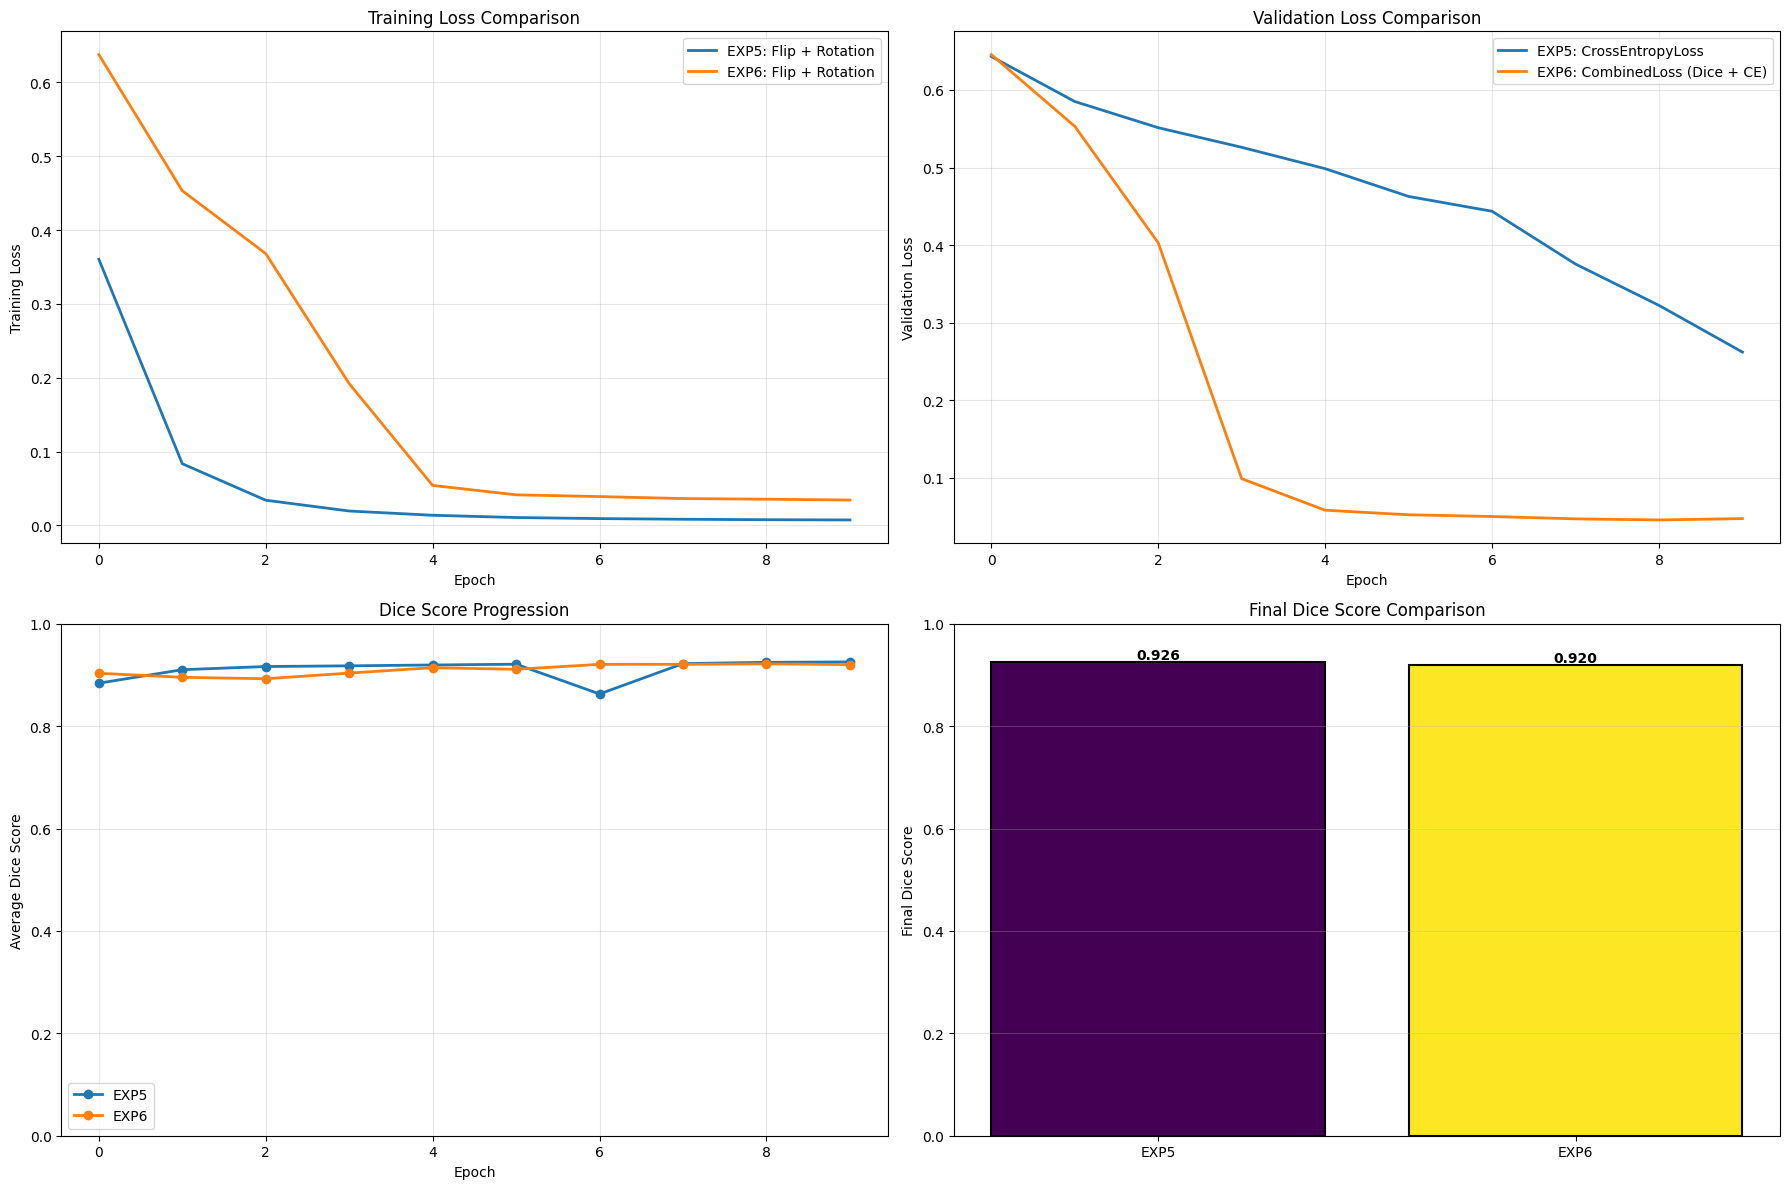

✅ Graphiques sauvegardés: experiments_comparison.png


In [18]:
print("\n" + "📊" * 35)
print("COMPARAISON GRAPHIQUE DES EXPÉRIENCES")
print("📊" * 35)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Training Loss
ax1 = axes[0, 0]
for exp_name, exp_data in EXPERIMENTS_RESULTS.items():
    history = exp_data['history']
    ax1.plot(history['train_loss'], label=f"{exp_name}: {exp_data['config']['augmentation']}", linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss')
ax1.set_title('Training Loss Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Validation Loss
ax2 = axes[0, 1]
for exp_name, exp_data in EXPERIMENTS_RESULTS.items():
    history = exp_data['history']
    ax2.plot(history['val_loss'], label=f"{exp_name}: {exp_data['config']['loss']}", linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Validation Loss')
ax2.set_title('Validation Loss Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Average Dice Score
ax3 = axes[1, 0]
for exp_name, exp_data in EXPERIMENTS_RESULTS.items():
    history = exp_data['history']
    avg_dice_per_epoch = [np.mean(list(d.values())) for d in history['val_dice']]
    ax3.plot(avg_dice_per_epoch, label=exp_name, linewidth=2, marker='o')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Average Dice Score')
ax3.set_title('Dice Score Progression')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_ylim([0, 1])

# 4. Final Dice Scores (bar plot)
ax4 = axes[1, 1]
exp_names = list(EXPERIMENTS_RESULTS.keys())
final_dice_scores = [EXPERIMENTS_RESULTS[exp]['final_dice'] for exp in exp_names]
colors = plt.cm.viridis(np.linspace(0, 1, len(exp_names)))
bars = ax4.bar(exp_names, final_dice_scores, color=colors, edgecolor='black', linewidth=1.5)
ax4.set_ylabel('Final Dice Score')
ax4.set_title('Final Dice Score Comparison')
ax4.set_ylim([0, 1])
ax4.grid(True, alpha=0.3, axis='y')

# Ajouter les valeurs sur les barres
for bar, score in zip(bars, final_dice_scores):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{score:.3f}',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'experiments_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Graphiques sauvegardés: experiments_comparison.png")

Tableau comparatif final

In [19]:
print("\n" + "📋" * 35)
print("TABLEAU COMPARATIF FINAL")
print("📋" * 35)

# Créer le DataFrame
comparison_data = []
for exp_name, exp_data in EXPERIMENTS_RESULTS.items():
    config = exp_data['config']
    history = exp_data['history']
    
    row = {
        'Expérience': exp_name,
        'Augmentation': config['augmentation'],
        'Loss Function': config['loss'],
        'Base Filters': config['base_filters'],
        'Final Train Loss': history['train_loss'][-1],
        'Final Val Loss': history['val_loss'][-1],
        'Final Avg Dice': exp_data['final_dice'],
        'Best Avg Dice': max([np.mean(list(d.values())) for d in history['val_dice']])
    }
    comparison_data.append(row)

df_comparison = pd.DataFrame(comparison_data)

# Afficher
print("\n")
print(df_comparison.to_string(index=False))

# Sauvegarder en CSV
csv_path = os.path.join(RESULTS_PATH, 'experiments_comparison.csv')
df_comparison.to_csv(csv_path, index=False)
print(f"\n✅ Tableau sauvegardé: experiments_comparison.csv")

# Identifier la meilleure expérience
best_exp = df_comparison.loc[df_comparison['Final Avg Dice'].idxmax()]
print(f"\n🏆 MEILLEURE EXPÉRIENCE:")
print(f"  {best_exp['Expérience']}")
print(f"  Augmentation: {best_exp['Augmentation']}")
print(f"  Loss: {best_exp['Loss Function']}")
print(f"  Dice Score: {best_exp['Final Avg Dice']:.4f}")


📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋
TABLEAU COMPARATIF FINAL
📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋


Expérience    Augmentation            Loss Function  Base Filters  Final Train Loss  Final Val Loss  Final Avg Dice  Best Avg Dice
      EXP5 Flip + Rotation         CrossEntropyLoss            32          0.007363        0.262243        0.925607       0.925607
      EXP6 Flip + Rotation CombinedLoss (Dice + CE)            32          0.034315        0.047676        0.920404       0.921840

✅ Tableau sauvegardé: experiments_comparison.csv

🏆 MEILLEURE EXPÉRIENCE:
  EXP5
  Augmentation: Flip + Rotation
  Loss: CrossEntropyLoss
  Dice Score: 0.9256


Visualisation des prédictions (meilleure expérience)


🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯
VISUALISATION DES PRÉDICTIONS (Meilleure Expérience)
🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯


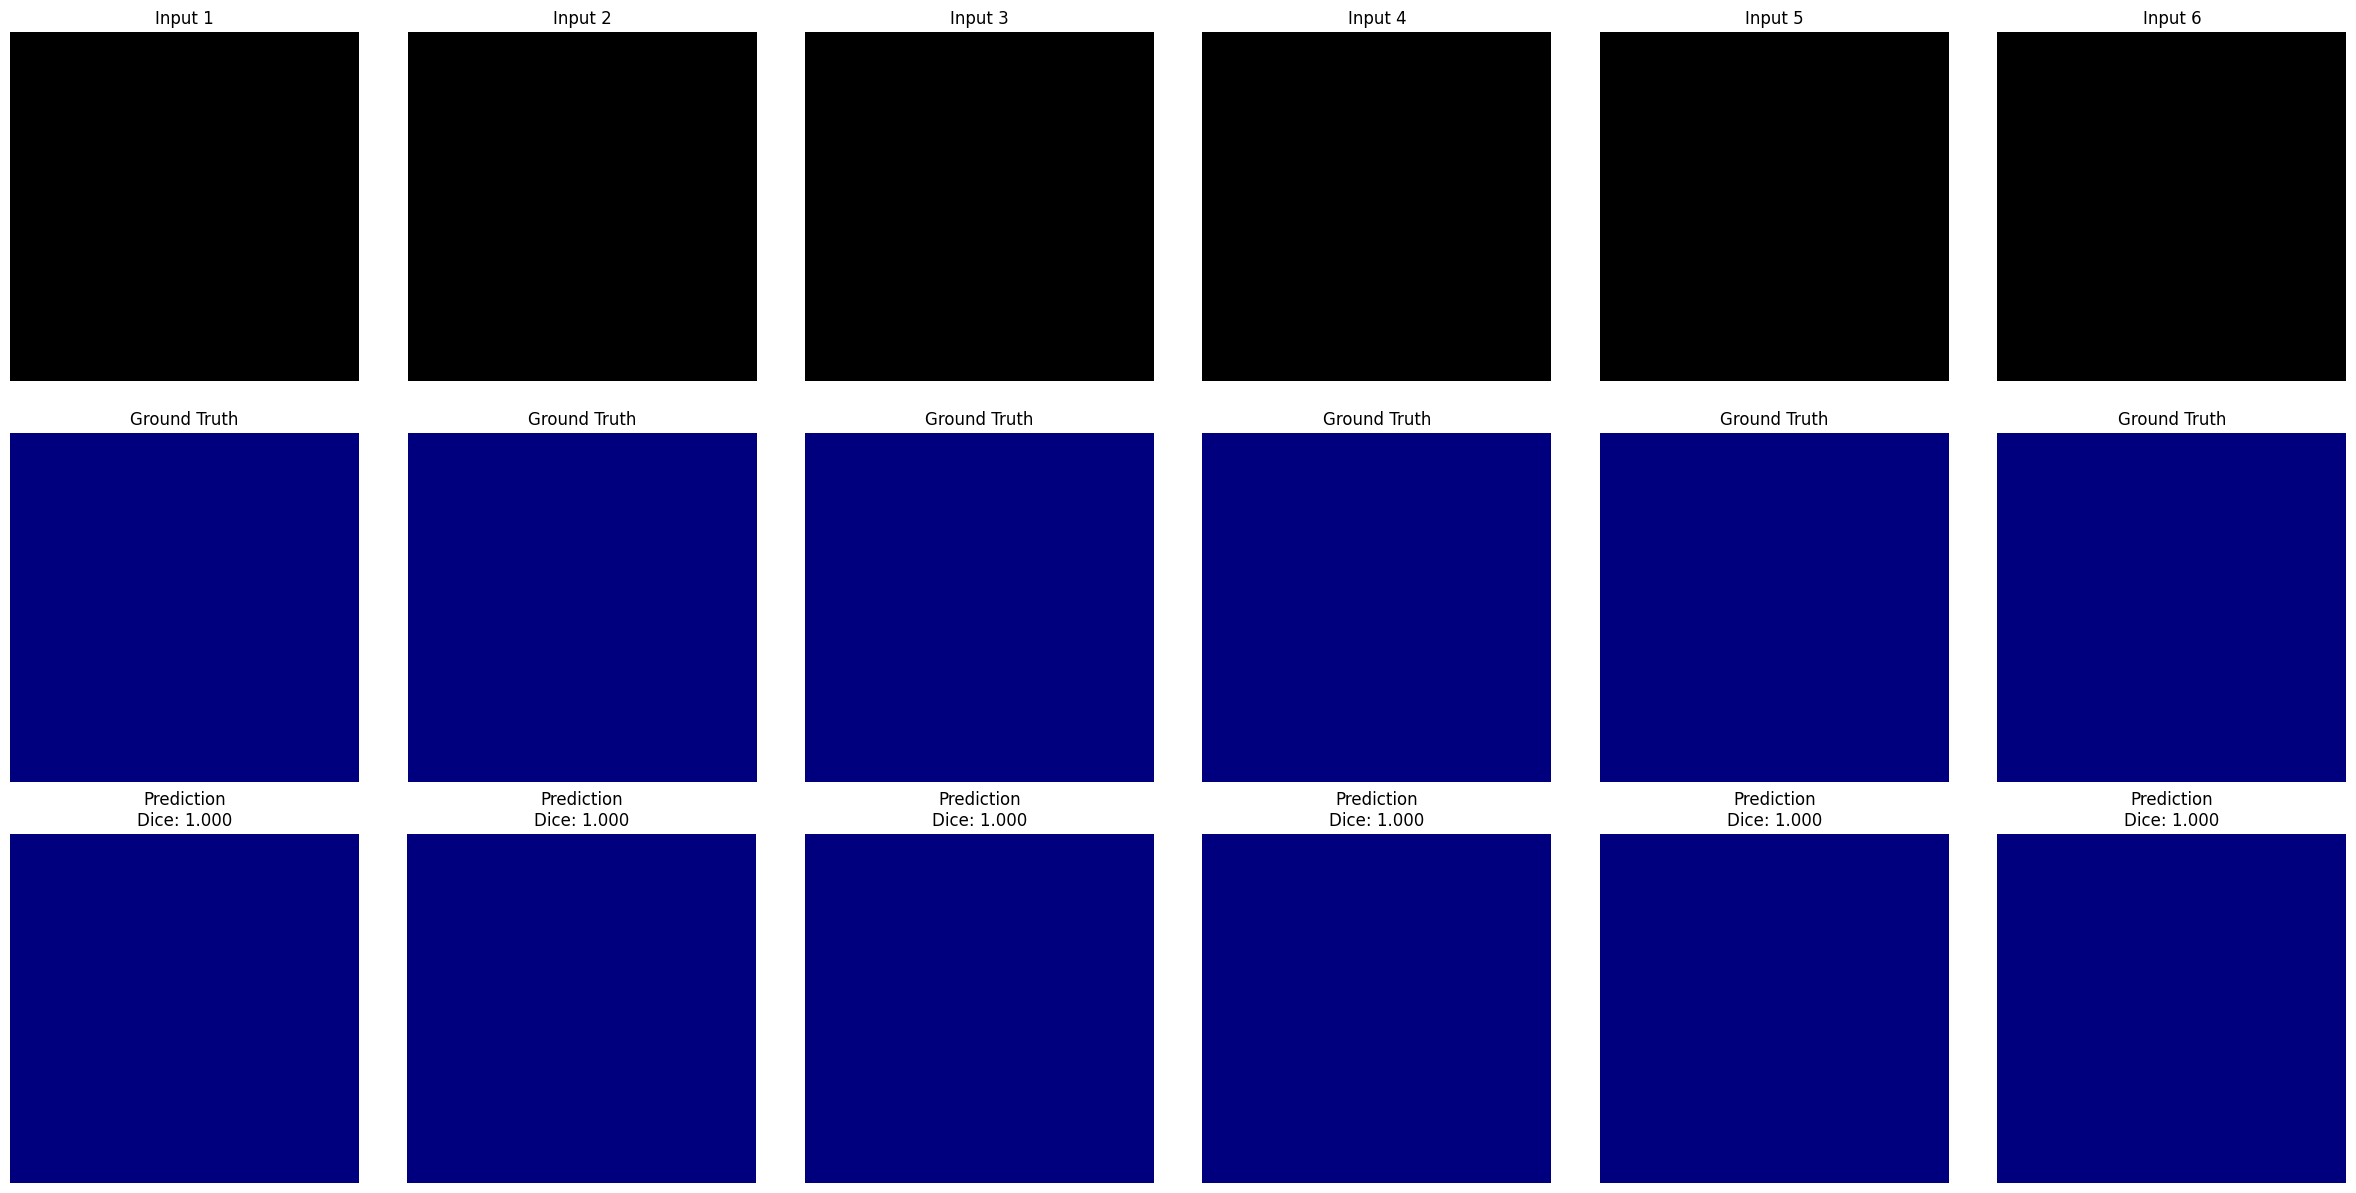

✅ Prédictions sauvegardées: predictions_best_model.png


In [20]:
"""
Visualiser quelques prédictions de la meilleure expérience
"""
print("\n" + "🎯" * 35)
print("VISUALISATION DES PRÉDICTIONS (Meilleure Expérience)")
print("🎯" * 35)

# Charger le meilleur modèle
best_exp_name = best_exp['Expérience']
best_model_path = os.path.join(RESULTS_PATH, f'{best_exp_name.lower()}_model.pth')

# Récupérer le bon modèle
if best_exp_name == 'EXP1':
    best_model = model_exp1
elif best_exp_name == 'EXP2':
    best_model = model_exp2
elif best_exp_name == 'EXP3':
    best_model = model_exp3
elif best_exp_name == 'EXP4':
    best_model = model_exp4
elif best_exp_name == 'EXP5':
    best_model = model_exp5
else:
    best_model = model_exp6

best_model.eval()

# Prendre quelques exemples de validation
val_images, val_labels = next(iter(val_loader_exp1))
val_images = val_images.to(device)
val_labels = val_labels.to(device)

with torch.no_grad():
    predictions = best_model(val_images)
    predictions = torch.argmax(torch.softmax(predictions, dim=1), dim=1)

# Visualiser 6 exemples
fig, axes = plt.subplots(3, 6, figsize=(24, 12))

num_samples = min(6, len(val_images))
for i in range(num_samples):
    # Image
    axes[0, i].imshow(val_images[i, 0].cpu().numpy(), cmap='gray')
    axes[0, i].set_title(f'Input {i+1}')
    axes[0, i].axis('off')
    
    # Ground Truth
    axes[1, i].imshow(val_labels[i].cpu().numpy(), cmap='jet', vmin=0, vmax=2)
    axes[1, i].set_title('Ground Truth')
    axes[1, i].axis('off')
    
    # Prédiction
    axes[2, i].imshow(predictions[i].cpu().numpy(), cmap='jet', vmin=0, vmax=2)
    
    # Calculer Dice pour cet exemple
    pred_np = predictions[i].cpu().numpy()
    gt_np = val_labels[i].cpu().numpy()
    dice_sample = []
    for c in range(3):
        pred_c = (pred_np == c)
        gt_c = (gt_np == c)
        intersection = (pred_c & gt_c).sum()
        union = pred_c.sum() + gt_c.sum()
        if union > 0:
            dice_sample.append(2.0 * intersection / union)
    
    axes[2, i].set_title(f'Prediction\nDice: {np.mean(dice_sample):.3f}')
    axes[2, i].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'predictions_best_model.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Prédictions sauvegardées: predictions_best_model.png")

Charger une slice avec hippocampe

✅ Slice 21 contient de l'hippocampe!


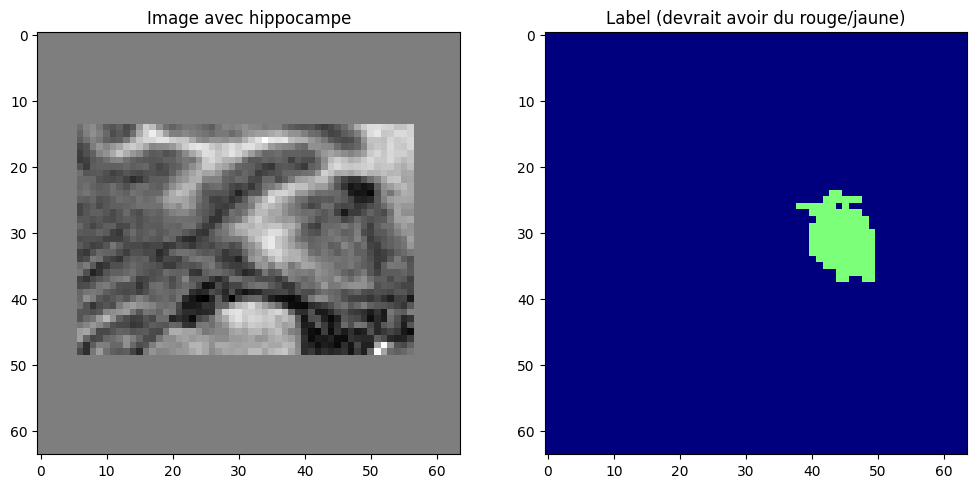

In [16]:
# Chercher une slice qui contient de l'hippocampe
val_dataset = val_dataset_exp1

for i in range(len(val_dataset)):
    _, label = val_dataset[i]
    
    # Vérifier si la slice contient de l'hippocampe (classe 1 ou 2)
    if torch.sum(label > 0) > 100:  # Au moins 100 pixels d'hippocampe
        print(f"✅ Slice {i} contient de l'hippocampe!")
        
        # Visualiser cette slice
        image, label = val_dataset[i]
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(image.squeeze(), cmap='gray')
        axes[0].set_title('Image avec hippocampe')
        axes[1].imshow(label, cmap='jet', vmin=0, vmax=2)
        axes[1].set_title('Label (devrait avoir du rouge/jaune)')
        plt.show()
        break

 Statistiques sur les slices

In [17]:
# Compter combien de slices ont de l'hippocampe
slices_with_hippo = 0
slices_without_hippo = 0

for i in range(min(1000, len(val_dataset_exp1))):
    _, label = val_dataset_exp1[i]
    
    if torch.sum(label > 0) > 0:
        slices_with_hippo += 1
    else:
        slices_without_hippo += 1

print(f"📊 STATISTIQUES (sur {min(1000, len(val_dataset_exp1))} slices):")
print(f"  Slices avec hippocampe: {slices_with_hippo}")
print(f"  Slices sans hippocampe: {slices_without_hippo}")
print(f"  Ratio: {slices_with_hippo / (slices_with_hippo + slices_without_hippo) * 100:.1f}%")

📊 STATISTIQUES (sur 1000 slices):
  Slices avec hippocampe: 392
  Slices sans hippocampe: 608
  Ratio: 39.2%


Visualisation des prédictions (SLICES AVEC HIPPOCAMPE)